# Wordgame Word2Vec features
Welcome to the second notebook in my wordgame project. In this notebook our goal is to extract a the similarity of the word pairs based on Word2Vec. Word2Vec is a model.. 

a) open tail
b) compute sim 
1) Compare sim with sim of random word pairs (shift) 
2) Plot all sim dists 
3) Plot specific. word 

In [46]:
#temp additions
sources_list = ['aspiecentral','atu2','bleeping_computer', 'classic_comics','ecig','gog','learn_english','sas','the_fishy','wrongplanet']


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.palplot(sns.color_palette("Paired", 10))

#because sometimes you need  to be more specific?
pal = sns.color_palette("Paired", 10)

#
df = pd.read_csv('../data/processed/wordgame_20170628_freq_basic.csv', dtype={'nt': np.bool, 'word1':str, 'word2':str})
#
df['word1'] = df['word1'].astype(str)
df['word2'] = df['word2'].astype(str)

sources_list = ['aspiecentral','atu2','bleeping_computer', 'classic_comics','ecig','gog','learn_english','sas','the_fishy','wrongplanet']

df.head()

,author,word1,word2,source,pair,pf,pf10,sourceID,tf,tf10,df,tfidf10,pfidf10,len1,len2,d_len,edit
0,1203,jailed,imprisoned,ecig,jailed:imprisoned,0.000003,0.000052,4,0.000021,0.000315,2,0.000564,0.000094,6,10,-4,7
1,5839,me,liverbird,wrongplanet,me:liverbird,0.000003,0.000033,9,0.000967,0.001564,10,0.001084,0.000023,2,9,-7,8
2,2962,reach,up,sas,reach:up,0.000003,0.000026,7,0.000036,0.000130,5,0.000143,0.000029,5,2,3,5
3,1066,owie,band-aid,ecig,owie:band-aid,0.000003,0.000052,4,0.000009,0.000105,2,0.000188,0.000094,4,8,-4,7
4,5006,water,river,wrongplanet,water:river,0.000045,0.000266,9,0.001943,0.004560,10,0.003161,0.000185,5,5,0,3


In [2]:
from gensim.models.keyedvectors import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded word embeddings')

Loaded word embeddings


In [107]:
#
def inVocab(r):
    if (r.word1 in w2v_model.vocab) & (r.word2 in w2v_model.vocab):    
        return True
    return False


df['word1'] = df['word1'].apply(lambda x:x.replace(" ","_"))
df['word2'] = df['word2'].apply(lambda x:x.replace(" ","_"))                 
df['invoc'] = df.apply(inVocab, axis=1)

#
def calcVec(r): 
    if r.invoc:
        return (w2v_model.word_vec(r.word1), w2v_model.word_vec(r.word2)) 
    else:
        return (0,0)
    
df['wv1'],df['wv2'] = zip(*df.apply(calcVec, axis=1))

#
def similarity(r):
    if r.invoc:
        return w2v_model.similarity(r.word1, r.word2)
    else:
        return 0

df['sim'] = 0    
df['sim'] = df.apply(similarity, axis=1) 
print("finished")

print("Percentage of words in vocabulary: " + str(df['invoc'].mean()*100))

finished
Percentage of words in vocabulary: 82.7398843238


In [108]:
# remove a words (pairs) that are not in vocabulary
#df = df[df['invoc']]
#print("Number of remaining word pairs: " +str(len(df)))
print("Mean similariy score: " +str(df['sim'].mean()))

Mean similariy score: 0.222620822551


...

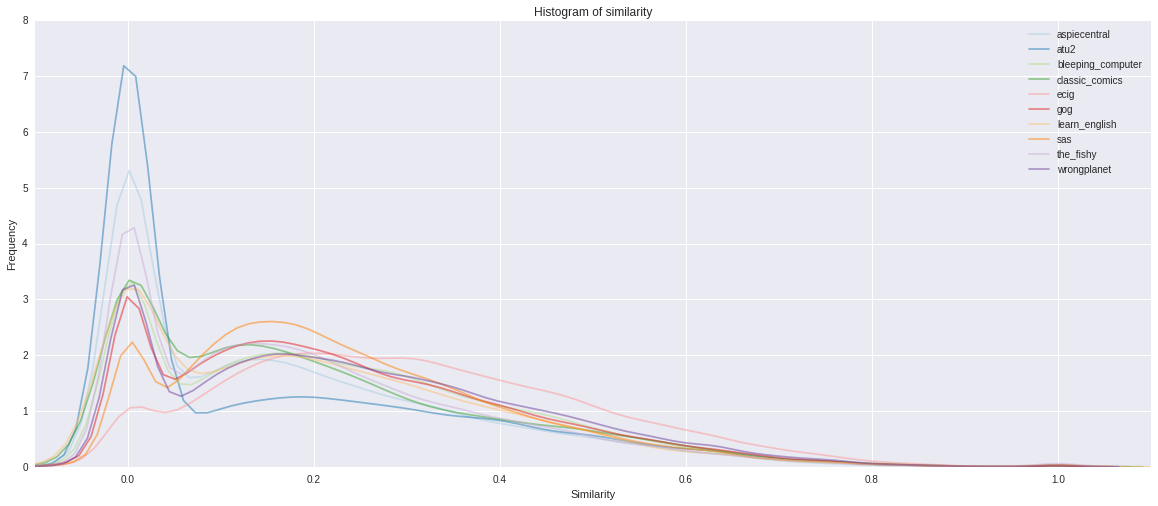

In [110]:
plt.figure(figsize=(20, 8))
for i in range(0,10,1):
    s = df[df['sourceID']==i]
    sns.kdeplot(s['sim'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of similarity')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-0.1,1.1])
plt.show()

...

# TSNE



In [72]:
from sklearn.manifold import TSNE

word_list1 = ['me','man','up','time','green','dog','house','lost','out','life']
word_list2 = word_list1
#word_list2 = ['you','woman','down','clock','grass','cat','home','found','in','death']

sample1 = df[(df['word1'].isin(word_list1))][:]
#sample1['col'] = 'blue'
sample1['word'] = sample1['word2']
sample1['wv'] = sample1['wv2']
sample1 = sample1[['word','wv','sourceID']]

sample2 = df[(df['word2'].isin(word_list2))][:]
#sample2['col'] = 'red'
sample2['word'] = sample2['word1']
sample2['wv'] = sample2['wv1']
sample2 = sample2[['word','wv','sourceID']]

#sample = pd.DataFrame()
sample = pd.concat([sample1, sample2])
sample['c'] = sample.groupby(['word'])['word'].transform('count') 
 
print("Number of words in sample: "+ str(len(sample)))

#print(sample.head())
sample = sample.drop_duplicates(subset=['word','sourceID']) # or later?

print("Number of words in sample: "+ str(len(sample)))

Number of words in sample: 6124
Number of words in sample: 3684


In [73]:
# Compute reduced word-vectors
model = TSNE(random_state=24).fit_transform(sample['wv'].tolist()) 
sample['x'] = model[:,0]
sample['y'] = model[:,1]

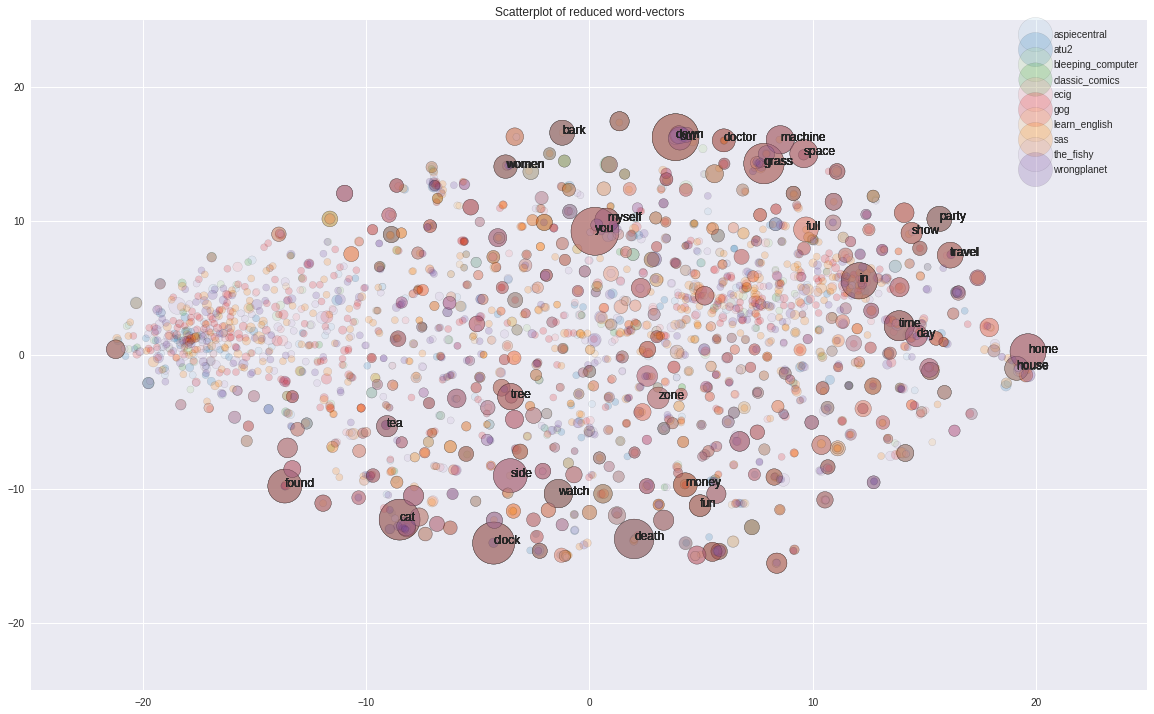

In [74]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(12)
for i in range(0,10):
    s = sample[sample['sourceID']==i]
    ax.scatter(s.x, s.y, marker='o', s=30+20*s.c, c=pal[i], alpha=0.2, label=sources_list[i])
    for j in range(0,len(s)):
        if(s.c.iloc[j] > 20):
            ax.annotate(s.word.iloc[j], (s.x.iloc[j], s.y.iloc[j]))
        
plt.title('Scatterplot of reduced word-vectors')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-25,25])
axes.set_ylim([-25,25])
plt.show()

...

In [123]:
def extend_word(r):
    if r.word1 not in w2v_model.vocab:
        return (r.word2, r.sim, 0)
    
    extended1 = r.word1 + "_" + r.word2 
    extended2 = r.word2 + "_" + r.word1
    extended3 = r.word1 + r.word2
    extended4 = r.word2 + r.word1
    
    sim1 = sim2 = sim3 = sim4 = 0
    if (extended1 in w2v_model.vocab):
        sim1 = w2v_model.similarity(r.word1, extended1)
    if (extended2 in w2v_model.vocab):
        sim2 = w2v_model.similarity(r.word1, extended2)
    if (extended3 in w2v_model.vocab):
        sim3 = w2v_model.similarity(r.word1, extended3)
    if (extended4 in w2v_model.vocab):
        sim4 = w2v_model.similarity(r.word1, extended4)
        
    best_sim = r.sim
    best_word = r.word2
    if(sim1 > best_sim):
        best_sim = sim1
        best_word = extended1
    if(sim2 > best_sim):
        best_sim = sim2
        best_word = extended2
    if(sim3 > best_sim):
        best_sim = sim3
        best_word = extended3
    if(sim4 > best_sim):
        best_sim = sim4
        best_word = extended4
            
    return (best_word, best_sim, (best_sim > r.sim))

df['word2_extended'],df['sim_extended'],df['isExt'] = zip(*df.apply(extend_word, axis=1))


print(df['sim_extended'].mean())
print("Percentage of pairs with improved similarity score: " + str(df['isExt'].mean()*100)) 

0.236848483447
Percentage of pairs with improved similarity score: 9.56334047827


0.0119720316998
0.00608727140277
0.0157299765039
0.0175901611957
0.013710325513
0.0124427147383
0.00638675832136
0.0196376345741
0.0208911047486
0.0110252374733


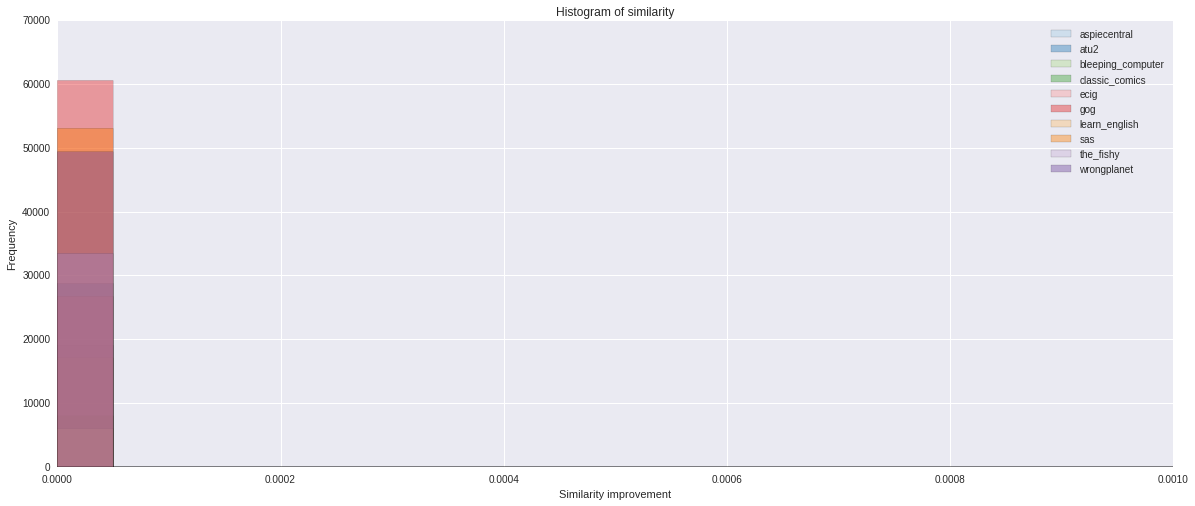

In [137]:
plt.figure(figsize=(20, 8))
for i in range(0,10,1):
    s = df[df['sourceID']==i]
    diff = s['sim_extended']-s['sim']
    print(diff.mean())
    sns.distplot(s['sim_extended']-s['sim'], bins=np.arange(0,0.01,0.00005), kde=False, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of similarity')
plt.xlabel('Similarity improvement')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([0.0,0.001])
plt.show()